In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()

### Genetic Algorithm for minimization problem 

In [2]:
class Genetic_Algorithm:
    def __init__(self,populzation_size,generation_size,random_seed):
        self.n_pop = populzation_size      # no of population
        self.n_gen = generation_size       # no of generations
        self.seed = random_seed            # random seed
        return
    
    def init_sol(self,n_var=2,size=16):
        # generate initial population with binary chromosomes
        self.pop = np.random.choice([1,0],size=(n_var * size * self.n_pop),replace=True)
        self.pop = self.pop.reshape(self.n_pop,n_var * size)
        return
    
    def cost_func(self,func):
        # set cost function
        self.cost_func = func
        return
    
    # function for decoding binary chromosome
    def decode(self,chromosome):
        # Lower and upper bound
        x_lb = -6
        y_lb = -6

        x_ub = 6
        y_ub = 6
        
        # binary to decimal value for each bit
        bits = np.arange(16-1,-1,-1)
        binary_decoder = np.apply_along_axis(lambda x : 2**x,0,bits)

        size = len(chromosome)//2

        # separating x and y component from chromosome
        x_bin = chromosome[:size]
        y_bin = chromosome[size:]

        # compute scale factor for x and y
        x_scaler = (x_ub-x_lb)/((2**len(x_bin))-1)
        y_scaler = (y_ub-y_lb)/((2**len(y_bin))-1)

        # convert binary x and y to decimal 
        x_val = np.sum(binary_decoder[x_bin.astype(bool)])
        y_val = np.sum(binary_decoder[y_bin.astype(bool)])

        x_decode = (x_val * x_scaler) + x_lb
        y_decode = (y_val * y_scaler) + y_lb

        return (x_decode,y_decode)

    def get_fitness_val(self,chromosome):
        # get cost function values
        x_decode,y_decode = self.decode(chromosome)
        return self.cost_func(x_decode,y_decode)

    def tournament_selection(self,k=3):
        # select k candidate for becoming parents and do this till we get k candidate for size of the population
        candidates = np.random.choice(np.arange(0,self.n_pop),self.n_pop*k).reshape(self.n_pop,k)
        return candidates

    def get_family(self,parents_idx,fitness_values):
        # select best parent from k candidates
        values = fitness_values[parents_idx]  
        select_idx = np.argsort(values)[0]
        return parents_idx[select_idx]

    def cross_over(self,parents,pop,prob_crs_ovr=1):
        # get parents chromosome from population
        parent_1 = pop[parents[0]]
        parent_2 = pop[parents[1]]
        
        # corss over if random is less than probability of cross over
        random =  np.random.rand()
        
        # generate two position to cross over
        if random < prob_crs_ovr:
            idx_1 = np.random.randint(0,len(parent_1))
            idx_2 = np.random.randint(0,len(parent_2))

            # position 1 and position 2 should not be equal
            while idx_1 == idx_2:
                idx_2 = np.random.randint(0,len(parent_2))

            # position 1 should be before position 2
            if idx_1 < idx_2:
                pos_1 = idx_1
                pos_2 = idx_2
            else:
                pos_1 = idx_2
                pos_2 = idx_1
            
            # create childern by exchanging the middle part
            first_p1 = parent_1[:pos_1]
            mid_p1   = parent_1[pos_1:pos_2+1]
            last_p1  = parent_1[pos_2+1:]

            first_p2 = parent_2[:pos_1]
            mid_p2   = parent_2[pos_1:pos_2+1]
            last_p2  = parent_2[pos_2+1:]        

            child_1 = np.concatenate([first_p1,mid_p2,last_p1])
            child_2 = np.concatenate([first_p2,mid_p1,last_p2])
        else:
            child_1 = parent_1
            child_2 = parent_2
        return np.array([child_1,child_2])            

    def mutation(self,child,mutate_prob=0.2):
        # mutate gene where random number is less 0.2
        random = np.random.random(len(child))
        idx = np.where(random < mutate_prob)[0]
        
        # flip bits
        child[idx] = (~child[idx].astype(bool)).astype(int)
        return child

    def minimize(self):
        np.random.seed(self.seed)
        self.init_sol()
        best_value = []
        best_chromosome = []
        pop = self.pop
        
        for gen in range(self.n_gen):
            
            # get fitness values of all population
            fitness_values = np.apply_along_axis(self.get_fitness_val,1,pop)
            
            # get best solution from all the population
            best_idx = np.argmin(fitness_values)
            best_value.append(fitness_values[best_idx])
            best_chromosome.append(pop[best_idx])
            
            # generate k candidate for each parent selection
            # No of parent should be size of the population
            candidates = self.tournament_selection()
            family = np.apply_along_axis(self.get_family,1,candidates,fitness_values=fitness_values)
            
            # reshape family to have 2 parents i.e shape will 100*2 
            parents = family.reshape(int(self.n_pop/2),2)
            
            # create new population by crossover
            new_pop = np.apply_along_axis(self.cross_over,1,parents,pop=pop)
            
            # new population will be three dimensional array
            # convert 3D array to 2D array
            pop = np.vstack((new_pop[:,0,:],new_pop[:,1,:]))
            pop = np.apply_along_axis(self.mutation,1,pop)
        
        
        # choose the best value and best solution obtained from all generations 
        best_idx = np.argmin(best_value)
        best_min = best_value[best_idx]
        chromosome = best_chromosome[best_idx]
        best_x, best_y = self.decode(chromosome)
        self.best_value = best_value
        print('Best Solution occus in gen {} for x = {} ,y ={} and obj value {}'.format(best_idx,best_x, best_y,best_min))
        return                

In [3]:
# Himmelblau's function
def obj_func(x,y):
    obj_val_current = ((x**2)+y-11)**2+(x+(y**2)-7)**2
    return obj_val_current

In [4]:
ga = Genetic_Algorithm(200,100,89)
ga.cost_func(obj_func)
ga.minimize()

Best Solution occus in gen 9 for x = 3.5891966124971386 ,y =-1.8390478370336458 and obj value 0.002697606471496256


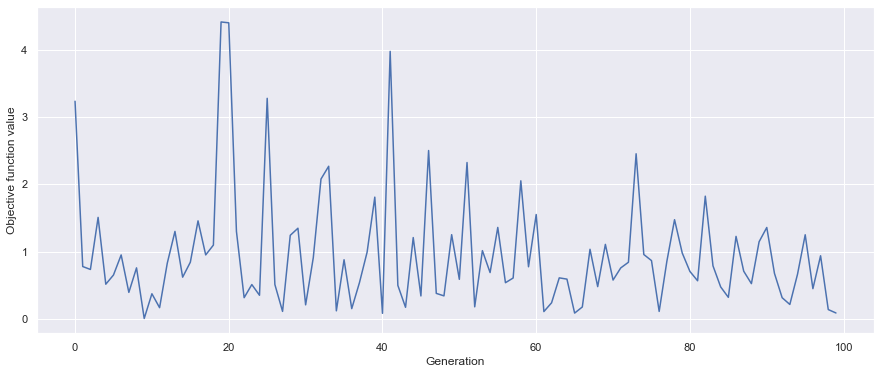

In [5]:
plt.figure(figsize=(15,6))
plt.xlabel('Generation')
plt.ylabel('Objective function value')
plt.plot(range(ga.n_gen),ga.best_value)

In [6]:
ga = Genetic_Algorithm(200,100,6)
ga.cost_func(obj_func)
ga.minimize()

Best Solution occus in gen 60 for x = -3.7809109636072327 ,y =-3.2845044632639047 and obj value 0.00016610242500272448


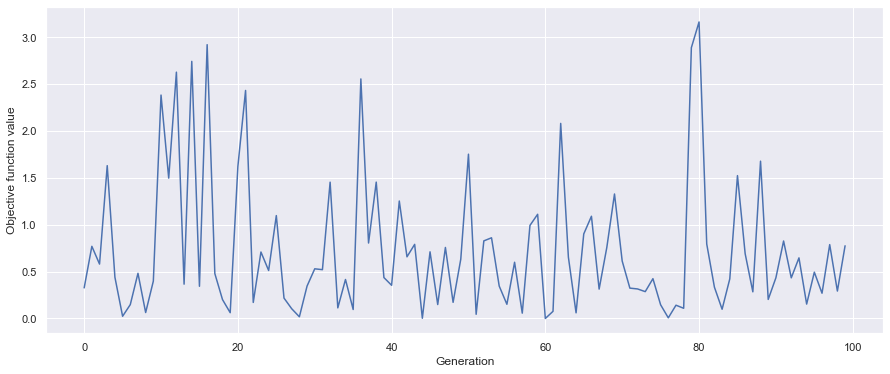

In [7]:
plt.figure(figsize=(15,6))
plt.xlabel('Generation')
plt.ylabel('Objective function value')
plt.plot(range(ga.n_gen),ga.best_value)